# Fortnite Heart Rate (HR) and Heart Rate Variability (HRV) Analysis

### Introduction

Fortnite is a free game created by Epic Games that has a 100-player PvP mode. This mode is essentially last man standing. As the number of players alive in the game decrease, nerves and fear tend to build up (unless you're a pro at this game and know what you're doing). I intend on measuring this fear via a heart rate monitor through two features - heart rate (HR) and heart rate variability (HRV).

#### Heart Rate Sensor

The Polar H7 is a Heart Rate Sensor (chest strap) that uses Bluetooth Low Energy (BLE) for communication. It is a strap that contains two electrodes, allowing it to measure the electrical activity of the heart to deliver continuous heart rate data.

#### Bluetooth Low Energy

The Python BLE Wrapper noted in the README is used to receive the Bluetooth packets. BLE contains GATT (Generic Attribute) Services which are collections of characteristics that encapsulate the behavior of part of a device. Each characteristic contains value fields.

In our case, the **Heart Rate (0x180D)** service is used, which contains multiple characteristics such as *Heart Rate Measurement*, *Body Sensor Location* and *Heart Rate Control Point*. Of interest to us is the **Heart Rate Measurement** characteristic which holds the wanted value fields **Heart Rate Value** and **RR-Interval**. 

The packets are received and decoded as shown below (every second):
![](img/hrpacket.png "Bluetooth Packet for Heart Rate Measurement")

#### Heart Rate (HR) and RR Intervals

HR is the average number of beats per minute (bpm). It doesn't require exact timings to each heart beat. For example, 60 bpm could mean 1 beat per second, or an average of 1 beat every 0.5s, 1.5s, 0.5s, 1.5s, ... and so on.

RR intervals are the time difference between each successive heart beat. The image below shows a QRS complex (the ECG waveform that corresponds to the contraction of the ventricles), where an RR interval is shown as the interval between successive R peaks. RR intervals are useful because they allow us to calculate Heart Rate Variability (HRV) measures.

![](img/rrinterval.png "RR Interval")

#### Heart Rate Variability (HRV)

Heart Rate Variability measures the changes in time between successive heart beats, where this time is normally measured in millseconds (ms) and is called the RR interval. A lower HRV tends to indicate stress from psychological events, exercise or other stressors. A higher HRV usually means that the body is healthy and has a strong ability to tolerate stress or recovers well from prior accumulated stress.

There are time-domain and frequency-domain measures that exist to calculate HRV. Some of these calculations allow us to gain an insight and measure the functioning of the Autonomic Nervous System (ANS). The ANS has two branches; sympathetic (SNS) and parasympathetic (PNS). The former mobilises the body’s resources for action under stressful conditions. In contrast, the latter relaxes the body and stabilises the body into a steady state.

### Collected Data

There are a few collected data files existing that contain the HR and RR intervals for different Fortnite games. These can be loaded in and analysed.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

# Bespoke HRV module
from heartbeat import *

from os import listdir
from os.path import isfile, join

In [38]:
def create_new_fig():
    """ Creates new figure

        :returns:
            An axis object
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    return ax

def plot_hr_signal(hrs):
    """ Plots HR signal

        :returns:
            Plot
    """
    ax = create_new_fig()
    print(len(hrs))
    timescale = np.linspace(0, len(hrs)-1, len(hrs))
    plt.title("Heart Rate (HR) Signal")
    ax.plot(timescale, hrs, label="HR", color='blue')
    ax.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("HR (bpm)")
    # Draw plot so that it doesn't block computation (show needs to follow at end of computation)
    plt.show()
    
def plot_tachogram(rr_intervals):
    """ Plots tachogram of RR intervals

        :returns:
            Plot
    """
    ax = create_new_fig()
    timescale = calc_timescale(rr_intervals)
    plt.title("RR Interval Tachogram")
    ax.plot(timescale, rr_intervals, label="RR Intervals", color='blue')
    ax.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("RR Interval (ms)")
    # Draw plot so that it doesn't block computation (show needs to follow at end of computation)
    plt.show() 
    
def plot_rmssd(rmssds):
    """ Plots windows of calculated rMSSD measures (per minute)

        :returns:
            Plot
    """
    ax = create_new_fig()
    timescale = np.linspace(0, len(rmssds)-1, len(rmssds))
    plt.title("rMSSD measures per minute")
    ax.plot(timescale, rmssds, label="rMSSD measures", color='blue')
    ax.legend()
    plt.xlabel("Time (mins)")
    plt.ylabel("rMSSD measures (ms)")
    # Draw plot so that it doesn't block computation (show needs to follow at end of computation)
    plt.show()  

In [41]:
# Data file strings
data_file_strings = [f for f in listdir("data") if isfile(join("data", f))]
hr_files = [s for s in data_file_strings if "hr" in s]
rr_files = [s for s in data_file_strings if "rr" in s]

### Fortnite Game 1

I went straight to Tilted Towers, the busiest place on the map and most likely place to die instantly (considering my amateur skill at this game). My average HR fluctuates around ~80 bpm for the majority, hitting peaks when confronting other players. I got to the last 12 people and found myself in the midst of a fight off with 3 other people - in which I completely bottled it and hit panic mode, making me reach around ~120 bpm! After dying, my HR slowly returns down to baseline (but not immediately).

##### Heart Rate Signal

978


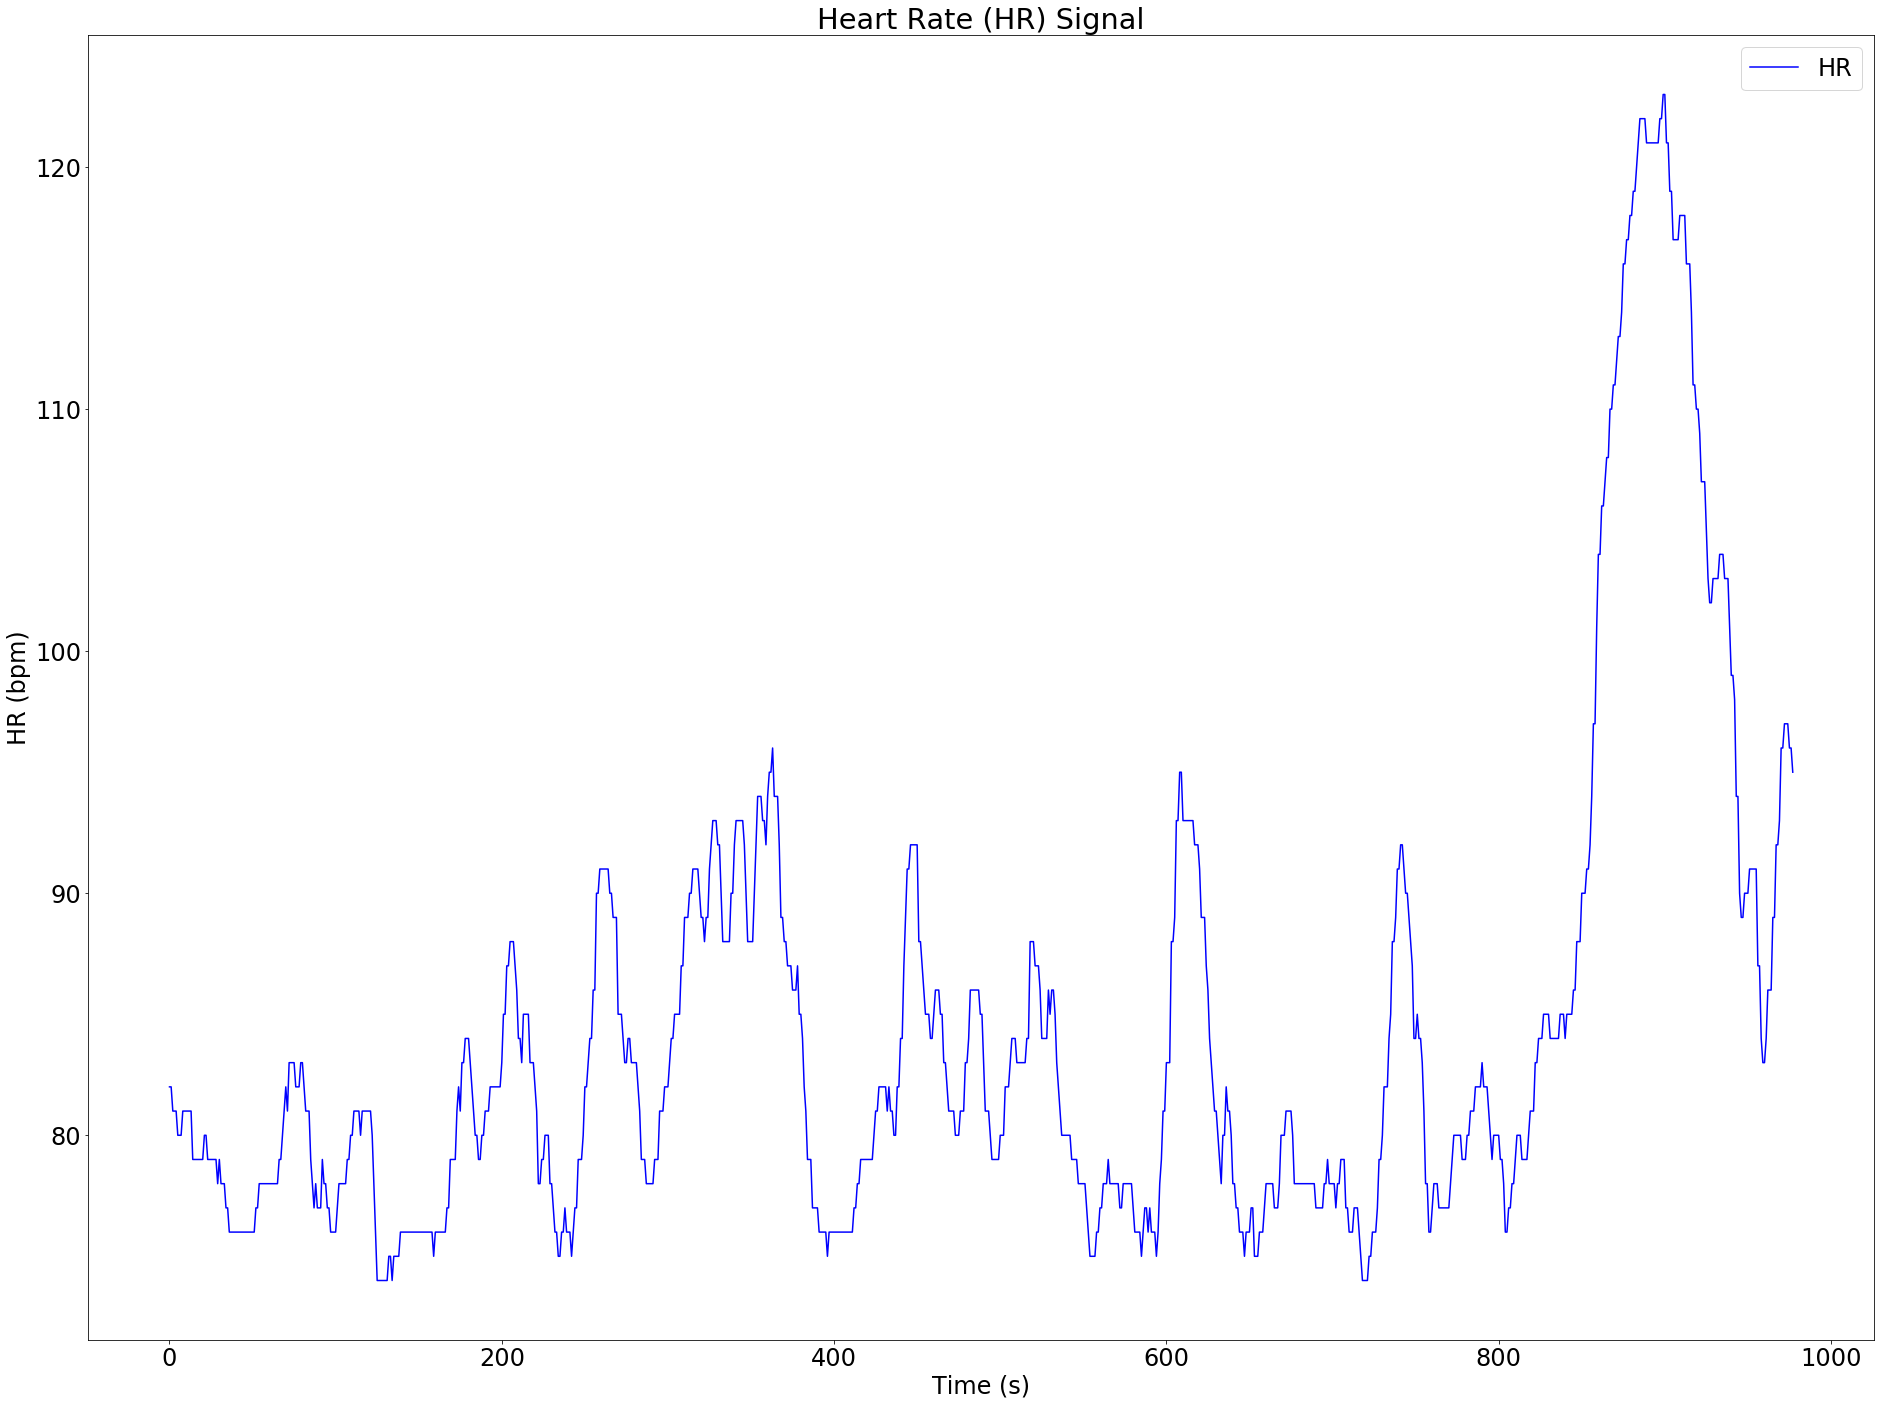

In [34]:
# Heart Rate Signal for Fortnite game when I came 12th overall
f_hr = open("data/" + hr_files[2], 'r')
hrs = [int(hr.rstrip()) for hr in f_hr.readlines()]
f_hr.close()

plot_hr_signal(hrs) 

##### RR Interval Tachogram

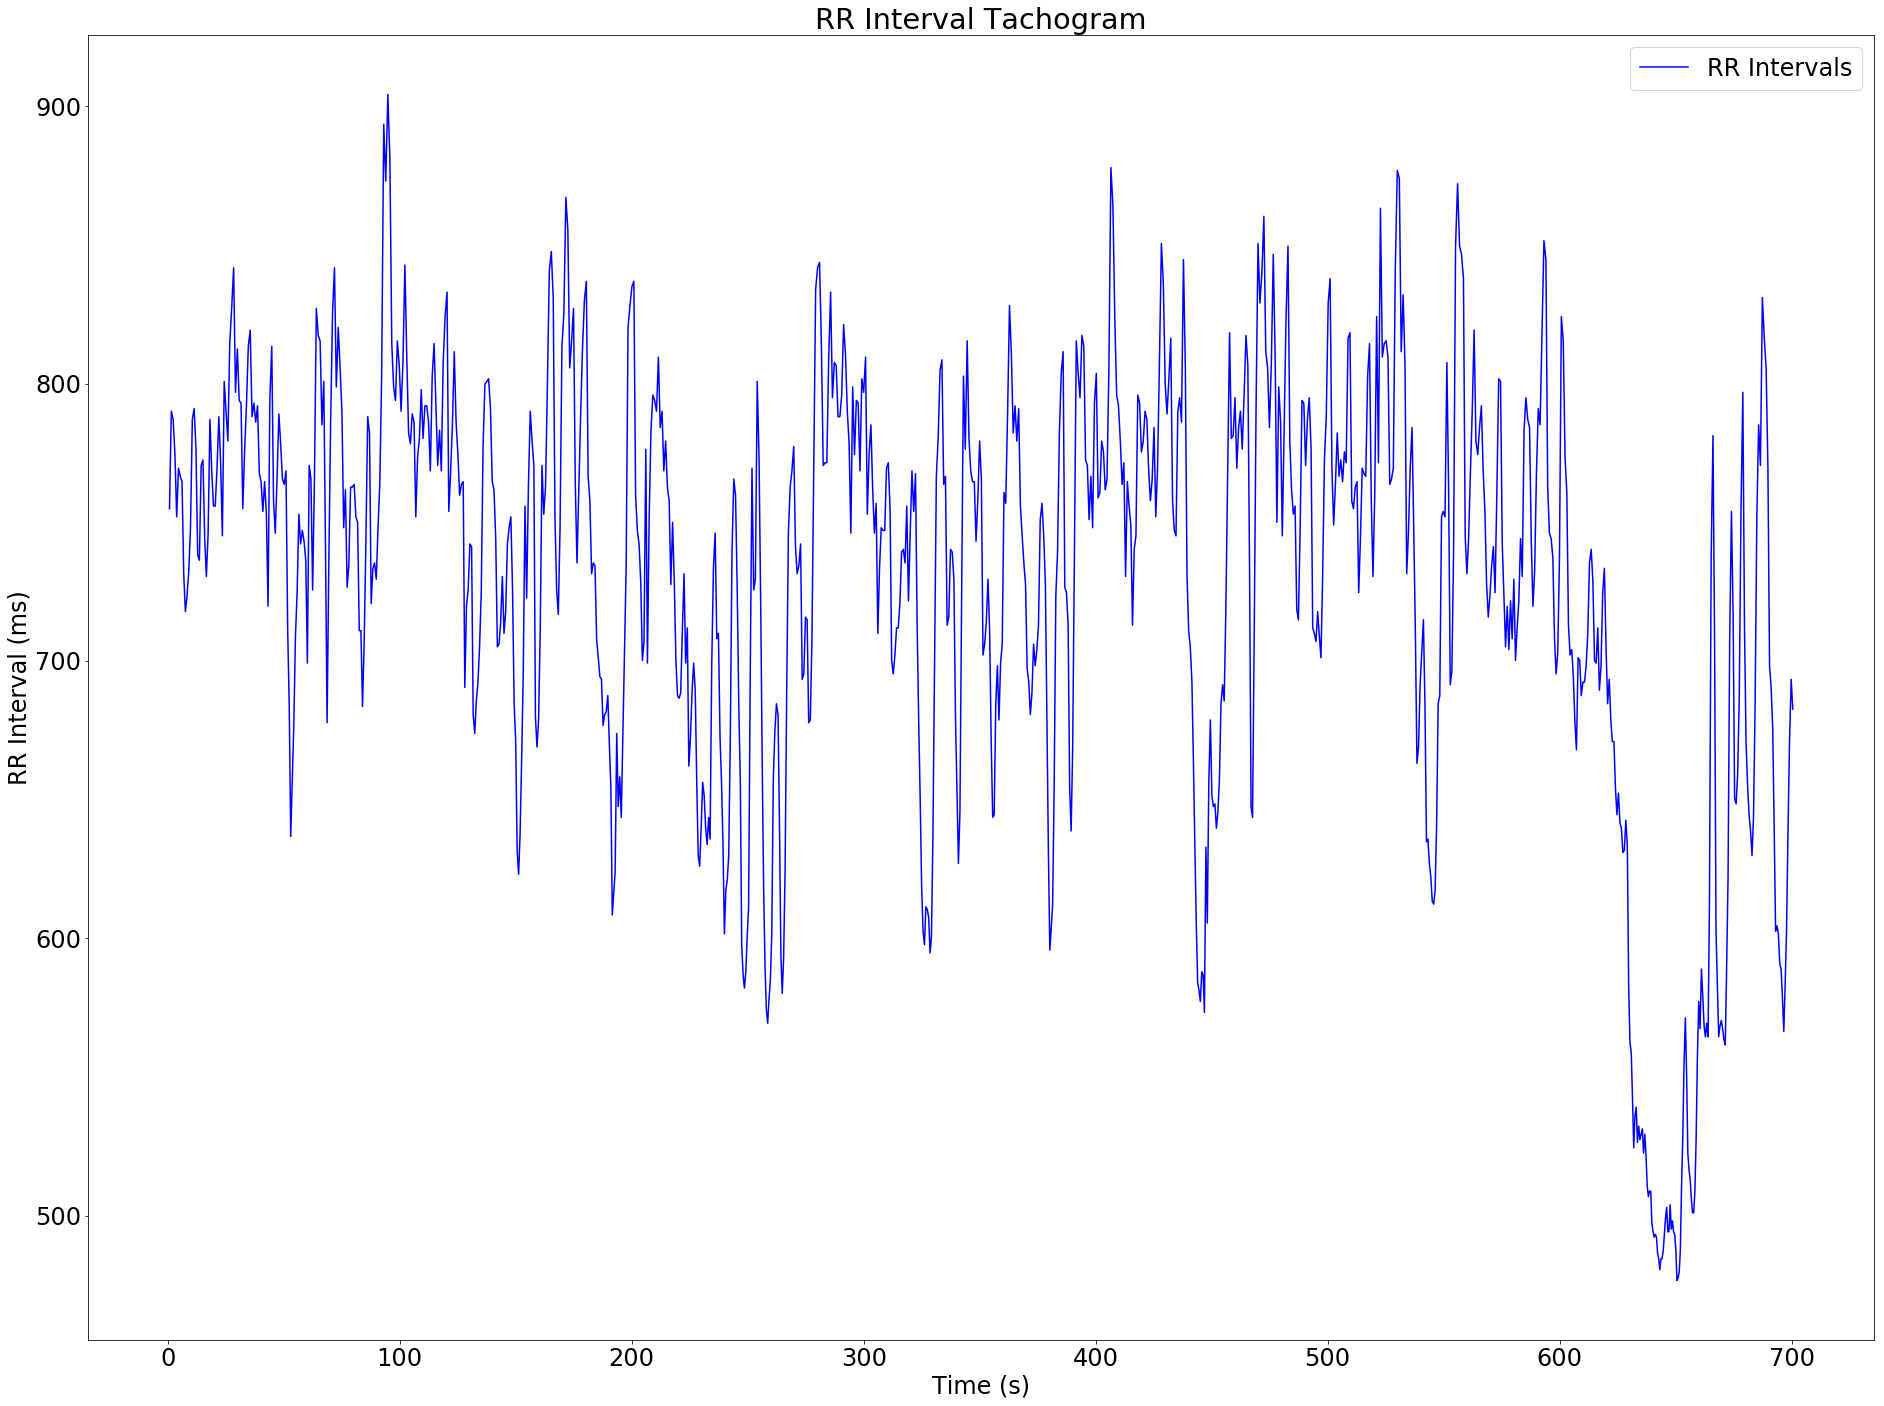

In [39]:
f_rr = open("data/" + rr_files[2], 'r')
rr_intervals = [float(rr.strip()) for rr in f_rr.readlines()]
f_rr.close()
plot_tachogram(rr_intervals)

#### Heart Rate Variability (HRV) Calculations

##### Root Mean Squared of the Successive Differences (rMSSD)

Root Mean Squared of the Successive Differences (rMSSD) is a popular HRV measure in the time-domain (the successive differences being the differences between neighboring RR intervals). A low value indicates high stress. As you can see here, around the time of my panic the rMSSD hit a trough of ~23ms. Also, initial entrance into Tilted Towers (first minute) shows quite a low value, showing how apprehensive I was.

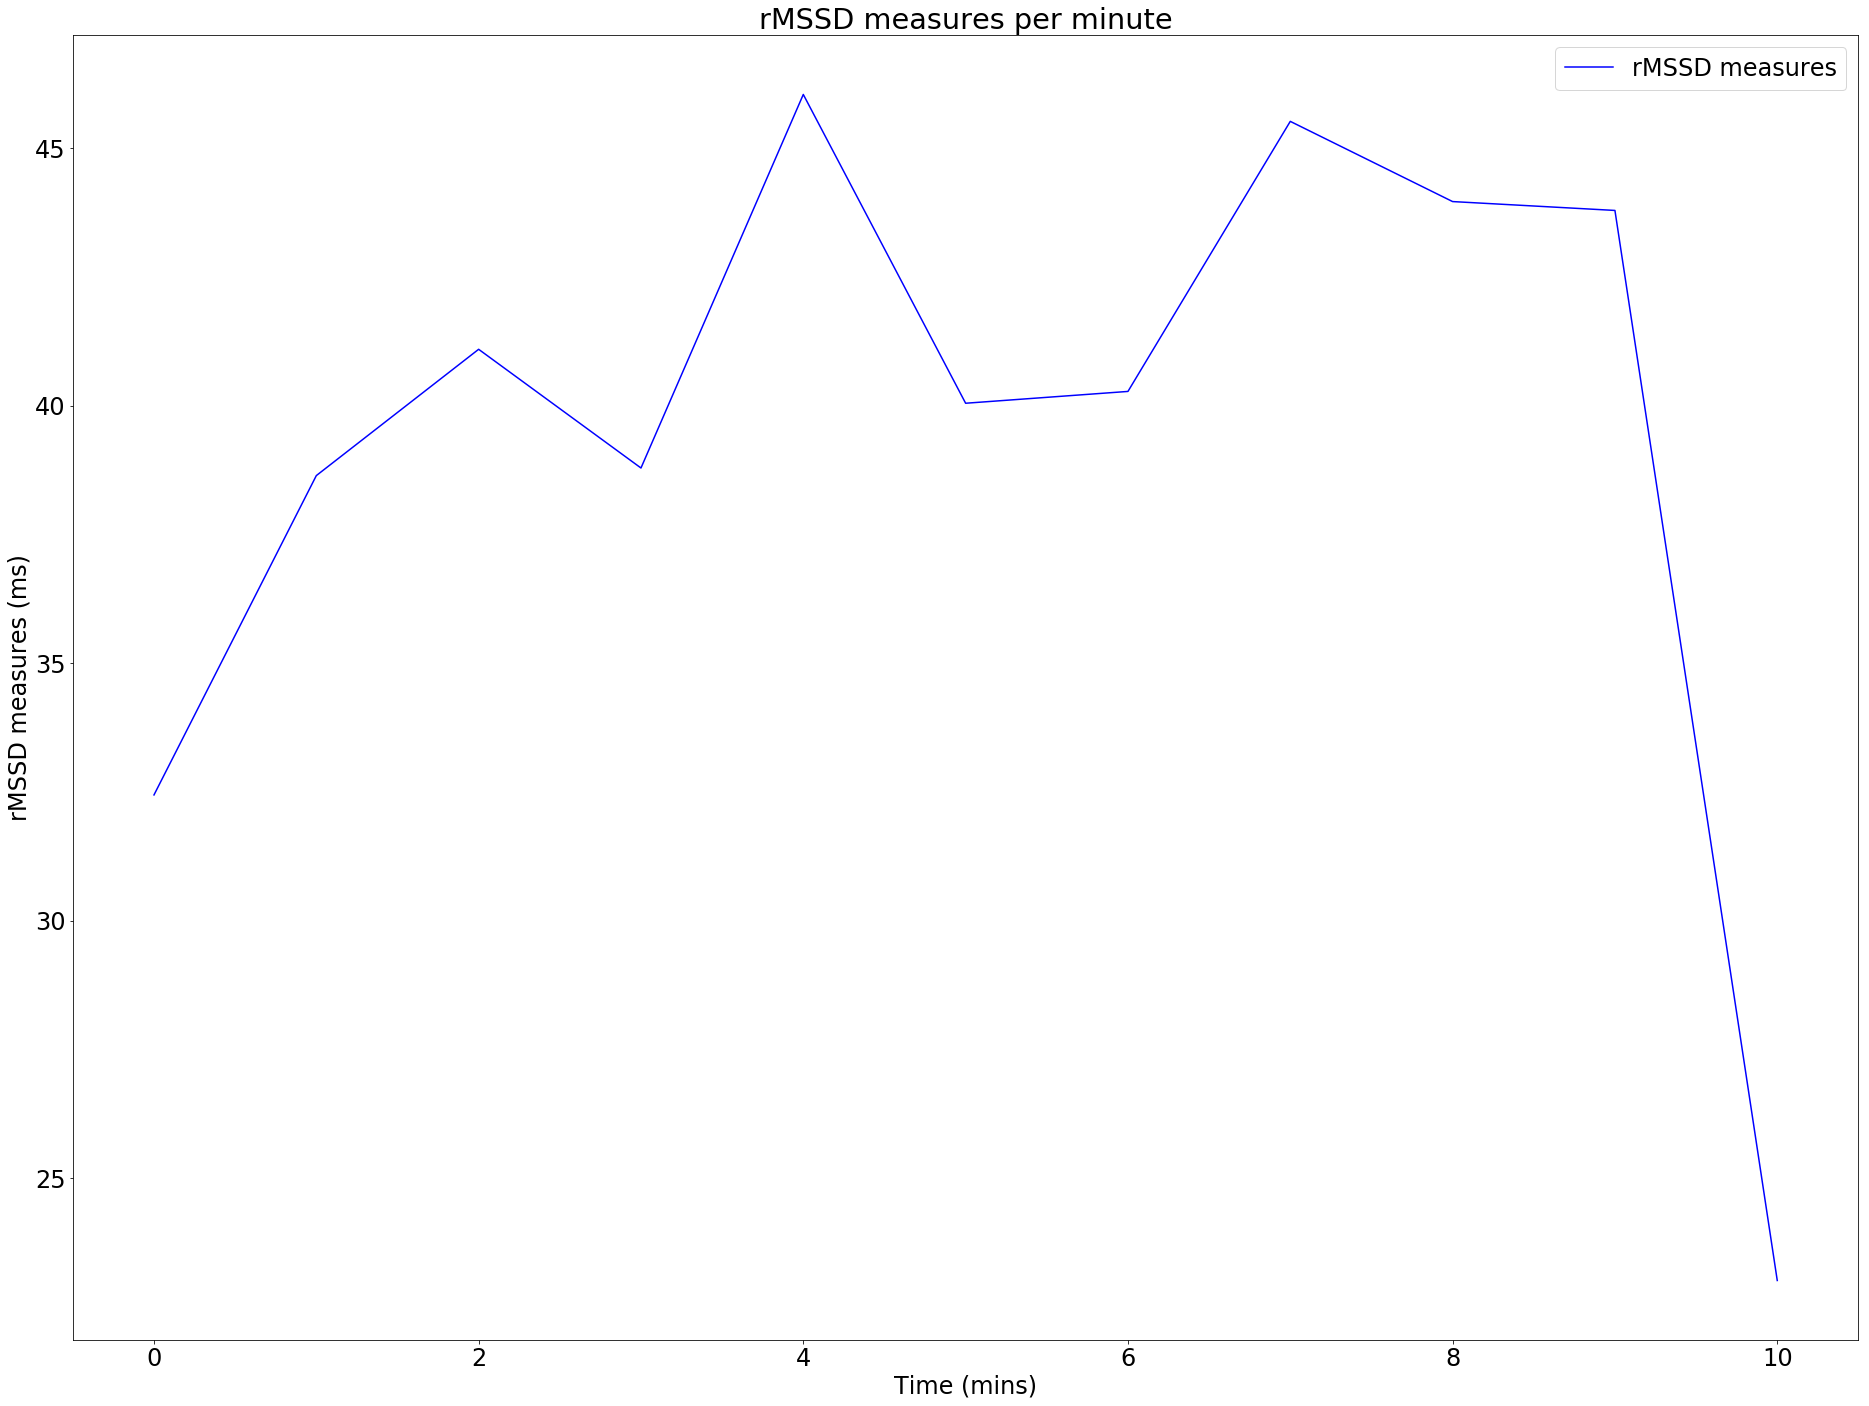

In [24]:
rr_windows = split_rrs(rr_intervals)
rmssds = []
for key in rr_windows:
    rrs = rr_windows[key]
    diff, sqdiff = calc_rr_differences(rrs)
    td_features = calc_time_domain_features(rrs, diff, sqdiff)
    rmssds.append(td_features['rmssd'])

# Remove last rMSSD as the window may not be 60 seconds and thus not comparable
del rmssds[len(rmssds)-1]
plot_rmssd(rmssds)